# Classification

<br/>
<br/>
<center>
<img src="images/linearly_separable.png" width="800">
</center>

This lecture will discuss basic types of classification algorithms and considerations for assessing and improving their accuracy. The focus will be on generalized linear models for discrimination of datapoints, and several other types of classification will be briefly explored.

* Classification basics
    - Problem statement for classification
    - Types of classification problems
    - Accuracy metrics

* Generalized linear models
    - Perceptron
    - Logistic regression
    - Support vector machines
    - Kernel SVMs

* Other classification models
    - Linear Discriminant Analysis
    - Naive Bayes
    - k-Nearest Neighbors
    - Decision trees and random forests

## Classification basics

### Problem statement for classification

A model that maps continuous or discrete inputs to a discrete (ordinal, categorical, or integer) output space.

There are two basic approaches to this problem:

#### Discriminative models:

These models are most similar to regression. Rather than learning a line\model that best represents the data we want to learn a line\model that best separates (discriminates) between different classes. For a binary classifier we can write this as:

$f(\vec{x}) > p$ if class 1

$f(\vec{x}) < p$ if class 2

where $p$ is some constant threshold that separates the classes.

Another way to think of this is that we will establish a function that estimates the probability of a point belonging to a particular class, given its features:

$P(y_i|\vec{x}) = f(\vec{x})$

Then the classes can be discretized by establishing probability cutoffs. These models **directly** solve the problem of estimating class probability.

#### Generative models

Generative models are somewhat less intuitive, but can be very powerful. In a generative model the goal is to solve the "inverse problem" of predicting the probability of features given a class label output. Mathematically:

$P(\vec{x}|y_i) = f(\vec{x})$

This is is counter-intuitive, but the model can then be used in conjunction with Bayes' rule to **indirectly** solve the classification problem. Bayes rule is:

$P(A|B) = \frac{P(B|A) P(A)}{P(B)} \rightarrow P(y_i|\vec{x}) = \frac{P(\vec{x}|y_i) P(y_i)}{P(\vec{x})}$

The $P(y_i)$ term is available from the data (number of times each class appears) and the $P(\vec{x})$ term is a constant so it can be dropped when computing relative probabilities.

Generative models are more difficult to understand, but they have a key advantage: new synthetic data can be generated by using the function $P(\vec{x}|y_i)$. This opens the possibility of iterative training schemes that systematically improve the estimate of $P(\vec{x}|y_i)$ (e.g. Generative Artificial Neural Networks) and can also aid in diagnosing problems in models. We will only briefly discuss generative models in this lecture.

<br>
<center>
<img src="images/discriminative_vs_generative.png" width="800">
</center>

### Features of classification problems

There are a few different types/features of classification problems:

* **Linearly separable**: A problem where it is possible to exactly separate the classes with a straight line (or plane) in the feature space.

<center>
<img src="images/linearly_separable.png" width="500">
</center>

* **Binary vs. Multi-class**: A binary classification problem has only 2 classes, while a multi-class problem has more than 2 classes. 

There are two approaches to dealing with multi-class problems:

1) Convert multi-class problems to binary problems using a series of "one vs. the rest" binary classifiers

<center>
<img src="images/OvA.png" width="400">
</center>

2) Consider the multi-class nature of the problem when deriving the method (e.g. kNN) or determining the cost function (e.g. logistic regression)

<center>
<img src="images/multiclass_cost.png" width="400">
</center>

In the end, the difference between these approaches tend to be relatively minor, although the training procedures can be quite different. One vs. the rest is more efficient for parallel training, while multi-class objective functions are more efficient in serial.

* **Balanced vs. Imbalanced**: A balanced problem has roughly equal numbers of examples in all classes, while an imbalanced problem has an (typically significantly) higher number of examples of some classes. 

There are a few basic strategies to overcome class imbalance:

1) Re-balancing the cost function to penalize mis-classification of the under-represented class more.

2) Undersampling: discarding information from over-represented class. This is inefficient since not all information is used.

<center>
<img src="images/class_imbalance.png" width="500">
</center>


3) Oversampling: add repeates of the under-represented class (very similar to re-balancing the cost function). This can lead to over-fitting of the decision boundary to the few examples of the under-represented class.

<center>
<img src="images/oversampling.png" width="500">
</center>

4) Resampling: Re-sample from the under-represented class, but add some noise. This is a robust solution, but requires some knowledge of the distribution of the under-represented data (e.g. generative models) or special techniques (e.g. SMOTE).

<center>
<img src="images/smote.png" width="500">
</center>

### Performance metrics

#### False positives and negatives

* Accuracy = (number correct)/(total) = (TP + TN)/(TP + TN + FP + FN)

* Precision = TP/(TP + FP)

* Recall = TP/(TP + FN)

<center>
<img src="images/precision_recall.png" width="500">
</center>

#### Confusion matrices

False positives and false negatives only apply to binary problems. The "confusion matrix" is a multi-class generalization of the concept, and can help identify which classes are "confusing" the algorithm.

<center>
<img src="images/confusion_matrix.png" width="500">
</center>

#### ROC curves

The "receiver operating characteristic", or ROC curve, is useful for models where a threshold is used. The area under the curve can be used as a metric for how well the model performs.

<center>
<img src="images/ROC_curve.jpg" width="300">
</center>

## Generalized Linear Models

We will work through some math and examine a toy dataset for "generalized linear" classification models. The toy dataset is simply two "blobs" that we will randomly generate using `scikit-learn`:

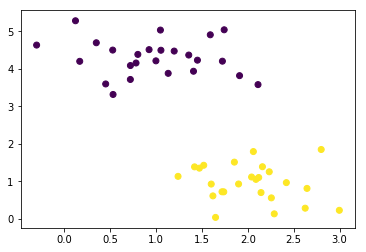

In [1]:
%matplotlib inline
import pylab as plt
import numpy as np
from sklearn.datasets.samples_generator import make_blobs

X, y = make_blobs(n_samples=50, centers=2, cluster_std=0.5, n_features=2, random_state=0)


#rescale
y_new = []
for yi in y:
    if yi == 0:
        y_new.append(-1)
    else:
        y_new.append(1)
y = np.array(y_new).reshape(y.shape)
        

fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c=y)

### The "perceptron"

We will start by considering a discrimination problem:

$f(\vec{x}) > p$ if class 1

$f(\vec{x}) < p$ if class 2

and let $f(\vec{x}) = \underline{\underline{X}}\vec{\beta}$, where $\underline{\underline{X}} = [\vec{x}, \vec{1}]$ similar to linear regression.

We can use $y$ as the output variable and arbitrarily assign "class 1" to 1 and "class 2" to -1, such that $p = 0$.

$\underline{\underline{X}}\vec{\beta} > 0$ if $y_i=1$ (class 1)

$\underline{\underline{X}}\vec{\beta} < 0$ if $y_i=-1$ (class 2)

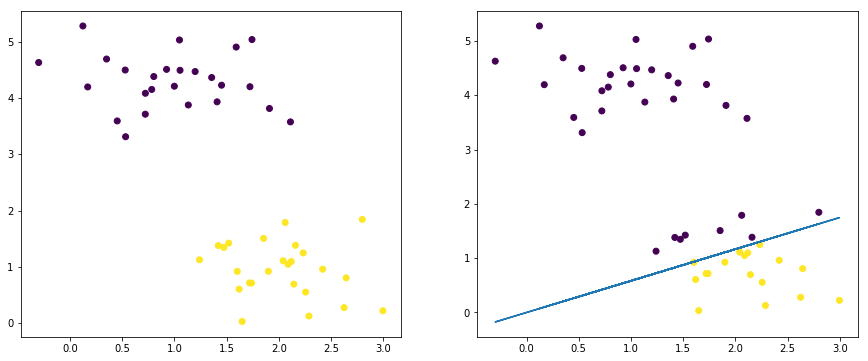

In [2]:
from  scipy.linalg  import solve

def add_intercept(X):
    intercept = np.ones((X.shape[0],1))
    X_intercept = np.append(intercept,X,1)
    return X_intercept

def linear_classifier(X,beta):
    X_intercept = add_intercept(X)
    p = np.dot(X_intercept,beta)
    return p > 0
    
beta = np.array([0,3.5,-6])
prediction = linear_classifier(X,beta)

fig, axes = plt.subplots(1,2,figsize=(15,6))
axes[0].scatter(X[:,0],X[:,1],c=y)
axes[1].scatter(X[:,0],X[:,1],c=prediction)


#plot line
m = -beta[1]/beta[2]
b = -beta[0]/beta[2]
axes[1].plot(X[:,0], m*X[:,0]+b, ls='-')

### Derivation: Find the equation for the line

This looks a lot like linear regression, but we still need an **objective function**. This is where things get tricky. Based on the definition of $\pm$1 for classes, we can re-write this as a single line:

$-y_i \underline{\underline{X}}\vec{\beta} < 0$

Convince yourself that this is true!

Now we can turn this into an equality by taking the maximum:

$max(0, -y_i \underline{\underline{X}}\vec{\beta}) = 0$

Now we are getting close. If a point $y_i$ is mis-classified then this will give a positive value, but if it is correctly classified it will return zero. Therefore we can get a cost for the entire dataset by summing the function over all data points:

$C(\vec{\beta}) = \sum_i max(0, -y_i \underline{\underline{X}}\vec{\beta})$

and we can find the optimal $\vec{\beta}$ by minimizing it with respect to $\vec{\beta}$

This is the "max cost" function, often commonly referred to as the "perceptron" model.

In [3]:
def max_cost(beta, X, y):
    X_intercept = add_intercept(X)
    Xb = np.dot(X_intercept,beta)
    return sum(np.maximum(0, -y*Xb))

print(max_cost(beta,X,y))

20.0525551737


#### Question: What will the optimal cost be if a dataset is linearly separable?

### Logistic Regression

There are two obvious problems with the perceptron:

1) There is a "trivial solution" at $\vec{\beta} = 0$

2) The cost function is not differentiable at all points

We can overcome the second problem by creating some smooth approximation of the maximum function. This is achieved using the "softmax" function:

$max(x,y) \approx soft(x,y) = log(exp(x) + exp(y))$

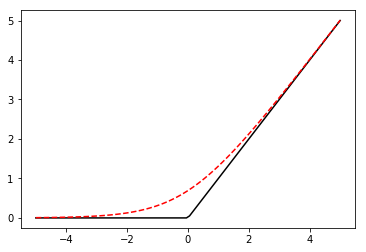

In [4]:
x = np.linspace(-5,5,100)

fig, ax = plt.subplots()

ax.plot(x, np.maximum(0,x), ls='-',color='k')
ax.plot(x, np.log(np.exp(0) + np.exp(x)), ls='--', color='r')


We can see that this also gets rid of the "trivial solution" at $\vec{\beta}=0$, so our problems are solved!

Now we can write a "softmax" cost function:

$C_{softmax}(\vec{\beta}) = \sum_i log\left\{1 + exp(-y_i \underline{\underline{X}}\vec{\beta})\right\}$

In [5]:
def softmax_cost(beta, X, y):
    X_intercept = add_intercept(X)
    Xb = np.dot(X_intercept,beta)
    exp_yXb = np.exp(-y*Xb)
    return sum(np.log(1 + exp_yXb))

print(softmax_cost(beta,X,y))

24.2275181869


This function is differentiable, so we can minimize this with respect to $\beta$ by setting the derivative equal to zero and solving for $\beta$:

$\frac{\partial C_{softmax}}{\partial \vec{\beta}} = 0$

It turns out this problem is not fully linear, and needs to be solved iteratively using e.g. Newton's method. The math is a little more complex than before, so we won't cover it in lecture, but it is covered in Ch. 4 of "Machine Learning Refined" if you are interested. This approximation is called **logistic regression**.

The key concept to understand is that $\vec{\beta}$ is determined by minimizing the softmax cost function. We can do this numerically for our toy model:

2.42787775841e-05
0.0


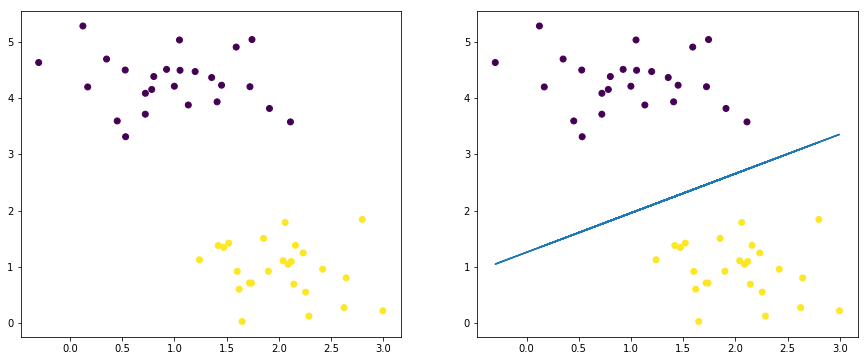

In [6]:
from scipy.optimize import minimize

result = minimize(softmax_cost, beta, args=(X,y))
beta_opt = result.x
print(softmax_cost(beta_opt,X,y))
print(max_cost(beta_opt,X,y))


prediction = linear_classifier(X,beta_opt)
fig, axes = plt.subplots(1,2,figsize=(15,6))
axes[0].scatter(X[:,0],X[:,1],c=y)
axes[1].scatter(X[:,0],X[:,1],c=prediction)


#plot line
m = -beta_opt[1]/beta_opt[2]
b = -beta_opt[0]/beta_opt[2]
axes[1].plot(X[:,0], m*X[:,0]+b, ls='-')

Note: There are other ways to derive "logistic regression". See Ch. 4 of ML refined for an alternative derivation.

### Support Vector Machines

Recall the two problems with the max cost function:

1) There is a "trivial solution" at $\vec{\beta} = 0$

2) The cost function is not differentiable at all points

Logistic regression uses a smooth approximation of the maximum to ensure differentiability, and the "trivial solution" goes away as a side effect.

An alternative approach is to directly eliminate the trivial solution by introducing a "margin" cost function, where we recognize that there will be some "buffer zone" between the classes:

<center>
<img src="images/margin_cost.png" width="500">
</center>

We can write this mathematically as:

$\underline{\underline{X}}\vec{\beta} \geq 1$ if $y_i=1$ (class 1)

$\underline{\underline{X}}\vec{\beta} \leq -1$ if $y_i=-1$ (class 2)

by using the same trick of multiplying by $y_i$ and taking a maximum we can write this as an equality:

$max(0, 1 -y_i \underline{\underline{X}}\vec{\beta}) = 0$

and the corresponding cost/objective function:

$C_{margin}(\vec{\beta}) = \sum_i max(0, 1-y_i \underline{\underline{X}}\vec{\beta})$

Note that this is very similar to the cost function for the perceptron, but now there is no trivial solution at $\vec{\beta} = 0$. However, we can solve this with a few approaches:

1) Use derivative-free numerical approximations

2) Replax $max$ with a differentiable function like $softmax$ or $max^2$

Let's see what happens with strategy 1:

In [7]:
def margin_cost(beta, X, y):
    X_intercept = add_intercept(X)
    Xb = np.dot(X_intercept,beta)
    return sum(np.maximum(0, 1-y*Xb))

print(margin_cost(beta,X,y))

30.3806107861


0.0
0.0


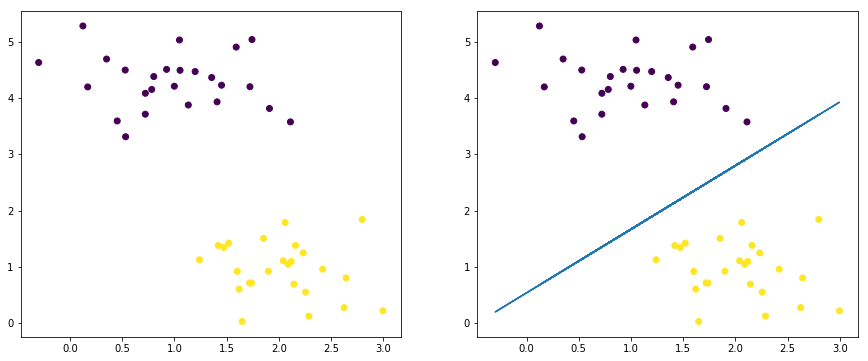

In [8]:
result = minimize(margin_cost, beta, args=(X,y))
beta_opt_margin = result.x
print(margin_cost(beta_opt_margin,X,y))
print(max_cost(beta_opt_margin,X,y))

prediction = linear_classifier(X,beta_opt_margin)
fig, axes = plt.subplots(1,2,figsize=(15,6))
axes[0].scatter(X[:,0],X[:,1],c=y)
axes[1].scatter(X[:,0],X[:,1],c=prediction)

#plot line
m = -beta_opt_margin[1]/beta_opt_margin[2]
b = -beta_opt_margin[0]/beta_opt_margin[2]
axes[1].plot(X[:,0], m*X[:,0]+b, ls='-')

It works, but we get a different solution from logistic regression. Let's see how this compares to the $max^2$ and $softmax$ approximations:

In [9]:
def margin_cost_squared(beta, X, y):
    X_intercept = add_intercept(X)
    Xb = np.dot(X_intercept,beta)
    return sum(np.maximum(0, 1-y*Xb)**2)

def margin_cost_softmax(beta, X, y):
    X_intercept = add_intercept(X)
    Xb = np.dot(X_intercept,beta)
    exp_yXb = np.exp(1-y*Xb)
    return sum(np.log(1 + exp_yXb))

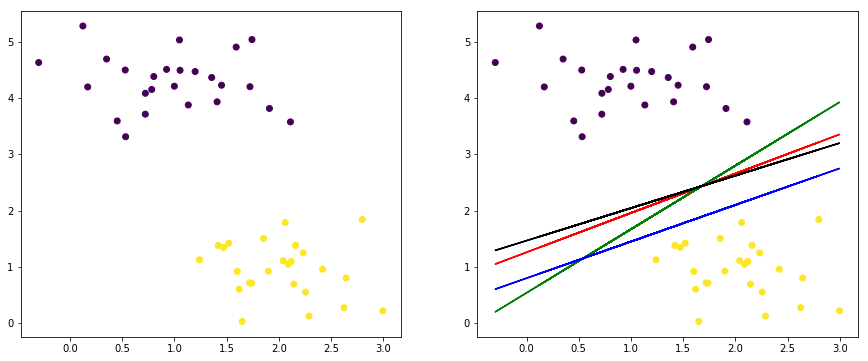

In [10]:
result = minimize(margin_cost_squared, beta, args=(X,y))
beta_opt_margin2 = result.x

result = minimize(margin_cost_softmax, beta, args=(X,y))
beta_opt_softmax = result.x

prediction = linear_classifier(X,beta_opt)
fig, axes = plt.subplots(1,2,figsize=(15,6))
axes[0].scatter(X[:,0],X[:,1],c=y)
axes[1].scatter(X[:,0],X[:,1],c=prediction)

#plot lines
def plot_line(ax, color, beta, X):
    m = -beta[1]/beta[2]
    b = -beta[0]/beta[2]
    ax.plot(X[:,0], m*X[:,0]+b, ls='-', color=color)

for beta_i, color in zip([beta_opt,beta_opt_margin, beta_opt_margin2, beta_opt_softmax],['r','g','b','k']):
    plot_line(axes[1], color, beta_i, X)

#### Which line is the best?

There are infinitely many lines that have equal cost for a linearly-separable dataset. The line that you find will depend on the approximation used, and can also depend on the initial guesses for the parameter $\beta$.

The idea of a "support vector machine" is to regularize the cost function so that the "margins" that define the buffer zone are maximized. This is intuitive since it allows the classifier to remain accurate even as data falls outside the original bounds.

<center>
<img src="images/margin_size.png" width="500">
</center>

Through geometrical arguments it is possible to prove that the width of the margin is equal to $2/||\vec{\tilde{\beta}}||_2$ where $\vec{\tilde{\beta}}$ does not include the intercept and $||.||_2$ is the 2-norm (see Ch. 4 of ML refined).

If we want to maximize the margin, then we want to minimize $||\vec{\beta}||_2$. We can achieve this by adding an $L_2$ penalty to the cost function:

$C_{SVM}(\vec{\beta}) = \sum_i max(0, 1-y_i \underline{\underline{X}}\vec{\beta}) + \lambda ||\vec{\beta}||_2 $

Support vector machines are simply an $L_2$-regularized version of the margin cost function. In practice it is common to use a smooth approximation of the margin cost function, and it is relatively simple to show that if the "softmax" approximation is used the cost function becomes very similar to that of logistic regression.

In practice, support-vector machines and $L_2$-regularized logistic regression are nearly indistinguishable and can be used interchangeably.

Let's apply this to our example dataset:

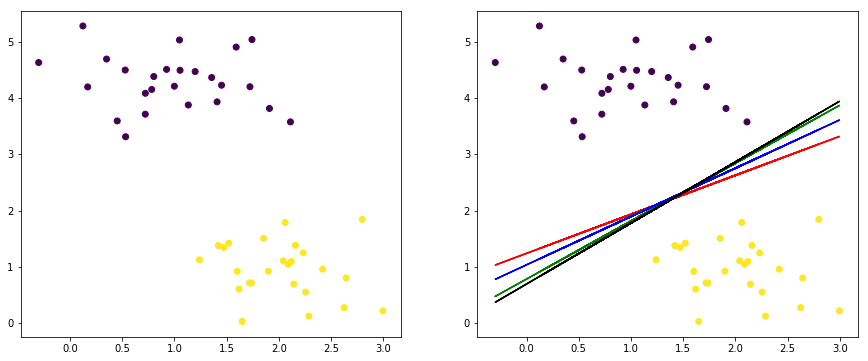

In [11]:
def regularized_cost(beta, X, y, cost_fn, lamda=1):
    cost = cost_fn(beta,X,y)
    cost += lamda*np.linalg.norm(beta,2)
    return cost
    
result = minimize(regularized_cost, beta, args=(X,y, margin_cost))
beta_SVM1 = result.x 

result = minimize(regularized_cost, beta, args=(X,y, margin_cost_softmax))
beta_SVM2 = result.x

result = minimize(regularized_cost, beta, args=(X,y, margin_cost_squared))
beta_SVM3 = result.x

result = minimize(regularized_cost, beta, args=(X,y, softmax_cost))
beta_SVM4 = result.x

prediction = linear_classifier(X,beta_SVM1)
fig, axes = plt.subplots(1,2,figsize=(15,6))
axes[0].scatter(X[:,0],X[:,1],c=y)
axes[1].scatter(X[:,0],X[:,1],c=prediction)

for beta_i, color in zip([beta_SVM1,beta_SVM2, beta_SVM3, beta_SVM4],['r','g','b','k']):
    plot_line(axes[1], color, beta_i, X)

There are still some differences, but the results are now much closer.

#### Question: Which cost function will be worst if there are known outliers (points far from the decision boundary)?

### Kernel SVM's

The regularized cousins of the perceptron all perform similarly well as long as the classes are **linearly separable**. However, what happens if this is not the case?

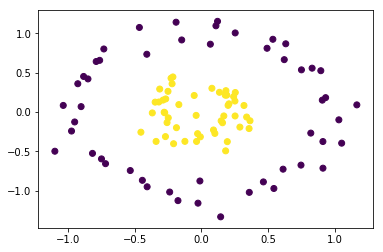

In [12]:
from sklearn.datasets.samples_generator import make_circles

X, y = make_circles(n_samples=100, factor=0.3, noise=0.1, random_state=0)


#rescale
y_new = []
for yi in y:
    if yi == 0:
        y_new.append(-1)
    else:
        y_new.append(1)
y = np.array(y_new).reshape(y.shape)
        

fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c=y)

Let's see what happens if we re-apply the SVM algorithm to this dataset:

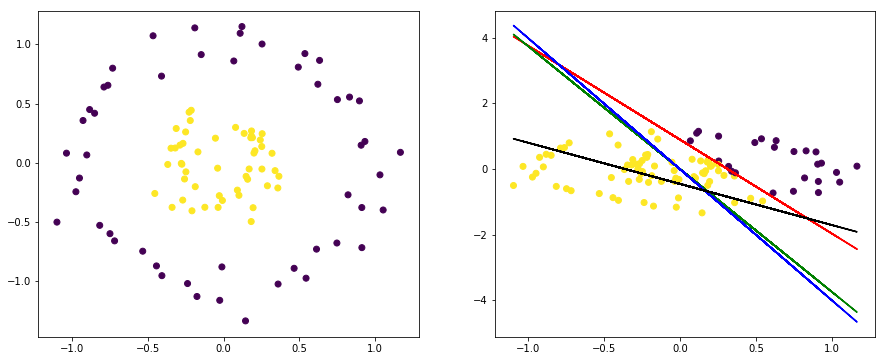

In [13]:
result = minimize(regularized_cost, beta, args=(X,y, margin_cost))
beta_SVM1 = result.x 

result = minimize(regularized_cost, beta, args=(X,y, margin_cost_softmax))
beta_SVM2 = result.x

result = minimize(regularized_cost, beta, args=(X,y, margin_cost_squared))
beta_SVM3 = result.x

result = minimize(regularized_cost, beta, args=(X,y, softmax_cost))
beta_SVM4 = result.x

prediction = linear_classifier(X,beta_SVM1)
fig, axes = plt.subplots(1,2,figsize=(15,6))
axes[0].scatter(X[:,0],X[:,1],c=y)
axes[1].scatter(X[:,0],X[:,1],c=prediction)

for beta_i, color in zip([beta_SVM1,beta_SVM2, beta_SVM3, beta_SVM4],['r','g','b','k']):
    plot_line(axes[1], color, beta_i, X)

All the variants of the cost function fail miserably! This is because the data is not linearly separable. We can solve this using the same trick as for generalized linear regression: create new non-linear features from the original data.

For example, in this problem let's add a new feature that is a Gaussian distribution centered at (0,0) with a standard deviation of 1:

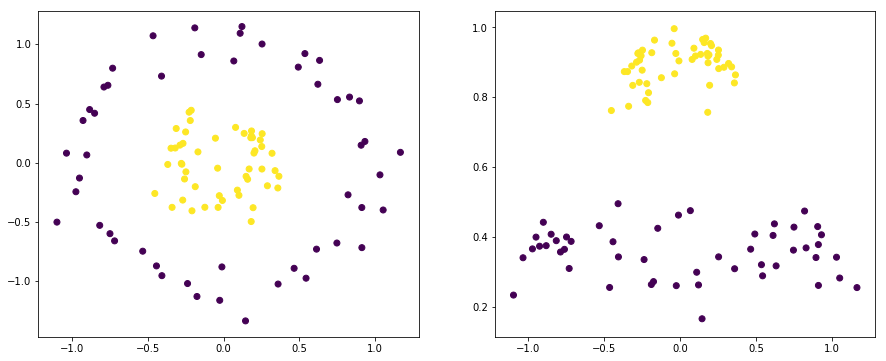

In [14]:
X_gauss = np.exp(-(X ** 2).sum(axis=1))

fig, axes = plt.subplots(1,2,figsize=(15,6))
axes[0].scatter(X[:,0],X[:,1],c=y)
axes[1].scatter(X[:,0],X_gauss,c=y)

Now we can add this as a feature and try again:

In [15]:
X_tot = np.append(X, X_gauss.reshape(X_gauss.size,1), axis=1)
print(X_tot.shape)

(100, 3)


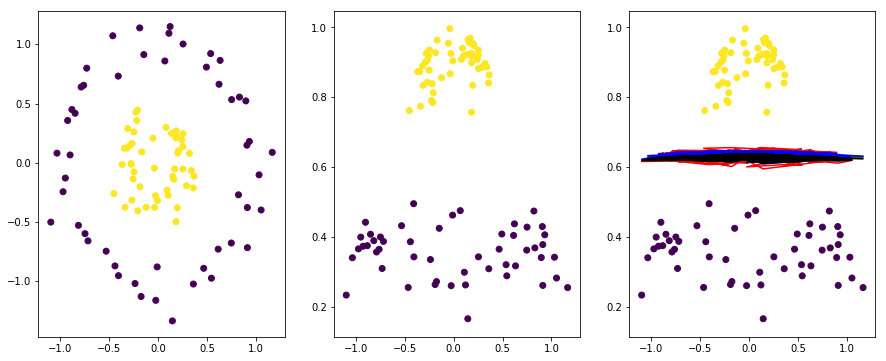

In [16]:
beta = np.ones(4)

result = minimize(regularized_cost, beta, args=(X_tot,y, margin_cost))
beta_SVM1 = result.x 

result = minimize(regularized_cost, beta, args=(X_tot,y, margin_cost_softmax))
beta_SVM2 = result.x

result = minimize(regularized_cost, beta, args=(X_tot,y, margin_cost_squared))
beta_SVM3 = result.x

result = minimize(regularized_cost, beta, args=(X_tot,y, softmax_cost))
beta_SVM4 = result.x

prediction = linear_classifier(X_tot,beta_SVM1)
fig, axes = plt.subplots(1,3,figsize=(15,6))
axes[0].scatter(X_tot[:,0],X_tot[:,1],c=y)
axes[1].scatter(X_tot[:,0],X_tot[:,2],c=y)
axes[2].scatter(X_tot[:,0],X_tot[:,2],c=prediction)


#plot lines
def plot_line_3d(ax, color, beta, X):
    m1 = -beta[1]/beta[3]
    m2 = -beta[2]/beta[3]
    b = -beta[0]/beta[3]
    ax.plot(X[:,0], m1*X[:,1] + m2*X[:,2] + b, ls='-', color=color)


for beta_i, color in zip([beta_SVM1,beta_SVM2, beta_SVM3, beta_SVM4],['r','g','b','k']):
    plot_line_3d(axes[2], color, beta_i, X_tot)

<center>
<img src="images/kernel_schematic.png" width="400">
</center>

#### How did we know to center this new feature at 0? What is a more general strategy?

Just like with kernel ridge regression, we can put a Gaussian at every single point and use this as a basis. This is called a "kernel SVM" and it is the classification equivalent of ridge regression. Rather than implementing this we can use the `scikit-learn` implementation.

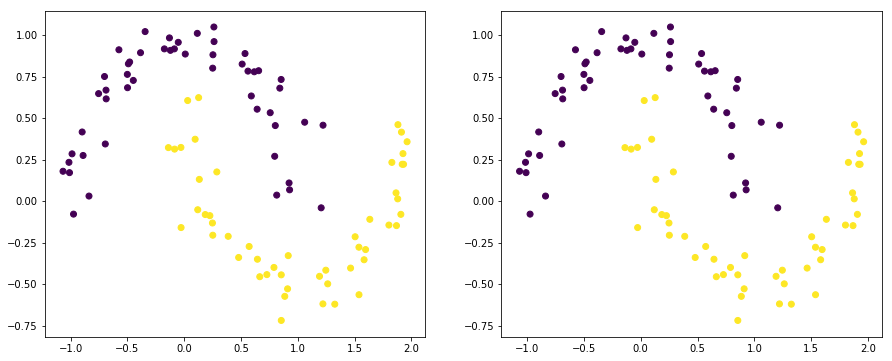

In [32]:
from sklearn.svm import SVC # "Support vector classifier"
from sklearn.datasets.samples_generator import make_moons

#X, y = make_circles(n_samples=100, factor=0.3, noise=0.1)

X, y = make_moons(n_samples=100, noise=0.1)

model = SVC(kernel='rbf', gamma=0.1, C=1e10)
model.fit(X, y)
y_predict = model.predict(X)

fig, axes = plt.subplots(1,2,figsize=(15,6))
axes[0].scatter(X[:,0],X[:,1],c=y)
axes[1].scatter(X[:,0],X[:,1],c=y_predict)

#### Question: How many continuous hyperparameters does the kernel SVM have?

We can also visualize the decision function to better understand what is happening:

In [33]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    if plot_support:
        # plot support vectors
        ax.scatter(model.support_vectors_[:, 0],
               model.support_vectors_[:, 1],
               s=300, linewidth=1, facecolors='none', edgecolors='k');
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

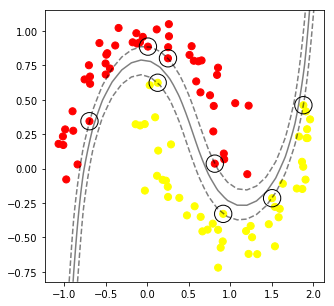

In [34]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model, ax = ax)

The points at the edge of the margin are called the "support vectors", hence the term "support vector machine". The inverse penalty cost, `C`, controls the "hardness" of the margins (harder margins = more overfitting), and the radial basis function kernel coefficient, `gamma` is inversely proportional to the width of the Gaussian kernels at each point.

Play around with the different datasets (circles, moons), the noise level, and the hyper-parameters of the model to get a feel for how this works under various scenarios.

## Other classification models

We will briefly discuss a few additional classification models and their advantages and disadvantages.

### Linear Discriminant Analysis (LDA)

LDA is a classifiction method similar to PCA. The key difference is that while PCA finds the axes of maximum variance for all points, LDA finds the axes of maximum variance *between clusters*.

<center>
<img src="images/lda_vs_pca.png" width="500">
</center>

LDA is an example of a **generative model**, despite the very confusing appearance of "discriminant" in its name. The reason is that LDA works by assuming that each class follows a Gaussian distribution with identical (co)variance. The parameters of the Gaussian distribution are estimated from the data, and used to transform each class into a standardized class with a uniform standard deviation of 1. These standardized classes are then treated as points and PCA is used to find the directions of maximum variance.

LDA is similar to PCA and PLS since it provides dimensional reduction along with classification.

#### LDA steps:

* Compute the centerpoint of each cluster
* Compute intraclass covariance
* Compute interclass covariance
* Calculate the largest eigenvalues/eigenvectors of the composite covariance matrix
* Use hyperplanes perpendicular to the linear discriminant vectors to assign classes

We will step through this for a toy "blobs" dataset, then compare to the `scikit-learn` implementation.

#### Step 1: Compute class centroids

Mean Vector class 0: [ 0.98137069  4.28756914]

Mean Vector class 1: [ 2.02437058  0.95630346]



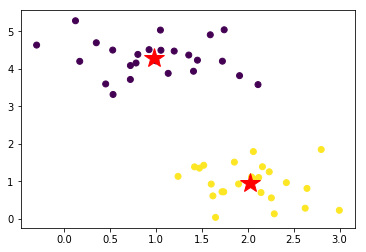

In [133]:
X, y = make_blobs(n_samples=50, centers=2, cluster_std=0.5, n_features=2, random_state=0)

mean_vectors = []
classes = [0,1]
for cl in classes:
    class_mean = np.mean(X[y==cl, :], axis=0)
    mean_vectors.append(class_mean)
    print('Mean Vector class {}: {}\n'.format(cl, mean_vectors[cl]))
    
fig, ax = plt.subplots()

ax.scatter(X[:,0], X[:,1], c=y)
for mv in mean_vectors:
    ax.plot(mv[0],mv[1],marker='*',markersize=20, color='r')

#### Step 2: Compute the intra-class (within class) covariance

Remember the definition of co-variance from PCA:

$\Sigma = \frac{1}{n-1} \left( (\mathbf{X} - \mathbf{\bar{x}})^T\;(\mathbf{X} - \mathbf{\bar{x}}) \right)$ 

Now we want the co-variance of each class, centered on the mean of that class.

In [134]:
class_covs = []
for cl, center in zip(classes, mean_vectors):
    subX = X[y==cl] #select only points from class
    subX_centered = subX - center
    cov = np.dot(subX_centered.T, subX_centered)
    cov = cov/(subX.size - 1)
    class_covs.append(cov) 
    print(cov, '\n')
    
print(len(class_covs))
class_covs[0].shape

[[ 0.17550194 -0.02104963]
 [-0.02104963  0.11865042]] 

[[ 0.10010032 -0.02006112]
 [-0.02006112  0.11665124]] 

2


(2, 2)

LDA assumes that all classes have the **same covariance**, so we will take an average over them to compute the **intra-class covariance matrix**.

In [135]:
intra = sum(class_covs)/len(class_covs)
print(intra)

[[ 0.13780113 -0.02055538]
 [-0.02055538  0.11765083]]


#### Step 3: Compute inter-class covariance

Now we also need to know the covariance matrix between different class centers. We will use the class means as points to achive this, and we will save some time by using `numpy`'s built-in covariance function:

In [136]:
center_array = np.array(mean_vectors)
inter = np.cov(center_array.T)
print(inter)

[[ 0.54392438 -1.73725486]
 [-1.73725486  5.54866553]]


#### Step 4: Take the largest eigenvalues/vectors of the composite covariance

We need to "divide" the inter-class (across class) covariance by the inter-class (within class) covariance. However, since we are dealing with matrices we use the inverse:

$\underline{\underline{C}}_{composite} = \underline{\underline{C}}_{intra}^{-1} \underline{\underline{C}}_{inter}$

This is called the "composite covariance matrix", and the linear discrimination axes can be determined by taking its eigenvalues.

[  0.         47.9538168]


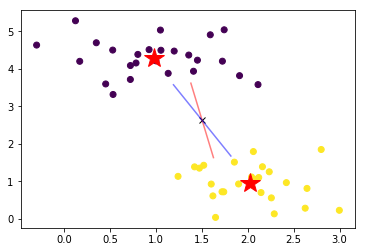

In [137]:
comp = np.dot(np.linalg.inv(intra), inter)
eig_vals, eig_vecs = np.linalg.eig(comp)
eig_vecs = eig_vecs.T

print(eig_vals)

fig, ax = plt.subplots()

ax.scatter(X[:,0], X[:,1], c=y)
for mv in mean_vectors:
    ax.plot(mv[0],mv[1],marker='*',markersize=20, color='r')
    
LDvec1 = eig_vecs[0]
LDvec2 = eig_vecs[1]

mu = np.mean(X, axis=0)

ax.plot([mu[0]],[mu[1]], marker='x', color='k')

#ax.plot([mu[0], mu[0] + LDvec1[0]*LDvals[0]],[mu[1],mu[1] + LDvec1[1]*LDvals[0]], ls='-', color='r', alpha=0.5) #<- plot eigenvectors scaled by eigenvalues
ax.plot([mu[0] - LDvec2[0], mu[0] + LDvec2[0]],[mu[1] -  LDvec2[1],mu[1] + LDvec2[1]], ls='-', color='r', alpha=0.5)

# compare to PCA
cov_all = np.cov(X.T)
PC_vals, PC_vecs = np.linalg.eig(cov_all)
PC_vecs = PC_vecs.T

PCvec1 = PC_vecs[0]
PCvec2 = PC_vecs[1]

ax.plot([mu[0] - PCvec2[0], mu[0] + PCvec2[0]],[mu[1] -  PCvec2[1],mu[1] + PCvec2[1]], ls='-', color='b', alpha=0.5)

#### Step 5: Find the perpendicular vector to use as the decision boundary

In LDA the decision boundary line or hyperplane is perpendicular to the LDA axis. We can find a perpendicular vector using the 90-degress rotation matrix:

$[[0, -1] \\ [1, 0]]$

In higher dimensions this can be achieved with cross-products.


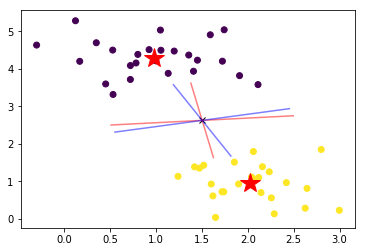

In [138]:
boundary = np.dot([[0, -1],[1,0]],LDvec2)
ax.plot([mu[0] - boundary[0], mu[0] + boundary[0]],[mu[1] -  boundary[1],mu[1] + boundary[1]], ls='-', color='r', alpha=0.5)

#compare to PCA boundary

PCboundary = np.dot([[0, -1],[1,0]],PCvec2)
ax.plot([mu[0] - PCboundary[0], mu[0] + PCboundary[0]],[mu[1] -  PCboundary[1],mu[1] + PCboundary[1]], ls='-', color='b', alpha=0.5)

#ax.set_xlim(-1,4)
#ax.set_ylim(0,5)
fig

Now we can assign classes by determining if a point is above/below the boundary line. There is no formal way for determining the threshold, but we have assumed that it is in the middle here. More sophisticated implementations typically optimize for it.

#### Question: Under what circumstances would the PCA and LDA vectors differ more substantially?

In practice it is much easier to just use the `scikit-learn` implementation of LDA:

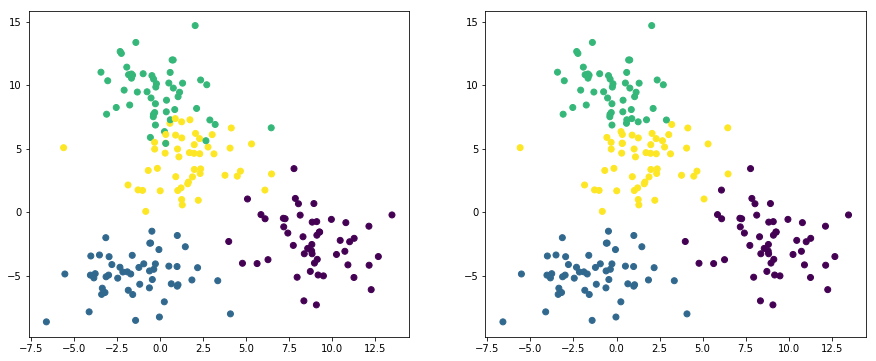

In [158]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X, y = make_blobs(n_samples=200, centers=4, cluster_std=2, n_features=2)
#X, y = make_moons(n_samples=100, noise=0.1)

lda = LinearDiscriminantAnalysis()
lda.fit(X,y)
y_pred = lda.predict(X)

fig, axes = plt.subplots(1,2,figsize=(15,6))
axes[0].scatter(X[:,0],X[:,1],c=y)
axes[1].scatter(X[:,0],X[:,1],c=y_pred)

Generate some different datasets using the code block above and explore the performance of LDA.

#### LDA summary:

LDA is a *generative model* that is based on the following assumptions about the distributions of the data:
* Each class is *normally distributed*
* The covariance of the distribution for each class is equivalent

**Advantages**
* Similar to PCA (relatively easy to understand)
* Easy to analyze the resulting low-dimensional space
* Relatively robust even if assumptions are violated

**Disadvantages**
* Assumes indpendent, normally distributed data
* Assumes identical covariance within each class
* Boundaries between classes must be linear

### Naive Bayes

Naive Bayes is another algorithm that is closely related to LDA. It also "naively" assumes that the data in each class is normally distributed. It also naively assumes that **features are not correlated** so that the covariance matrix of each class is diagonal. This allows the distribution of each class to be estimated by computing the standard deviation with respect to each feature.

The assumed Gaussian distribution for each class gives the probability function for $y$ (class) as a function of $X$ (features):

$P(\vec{x}|y_i) \sim \exp\left(\sum_j \frac{(x_j - \mu_i)^2}{2 \sigma_j^2}\right)$

This can be used with Bayes' formula to estimate $P(y_i|\vec{x})$:

$P(y_i|\vec{x}) = \frac{P(\vec{x}|y_i) P(y_i)}{P(\vec{x})}$

We won't go deep into the theory of Naive Bayes here, but it is implemented in `scikit-learn` and generally performs similarly to LDA.

### k-Nearest Neighbors

The kNN algorithm was covered in a previous lecture, but we will briefly review it here.

The class of a point is determined by letting its k-nearest neighbors "vote" on which class it should be in. The point is assigned to whichever class has the most votes. In the case of a tie, `k` is decreased by 1 until the tie is broken.

The advantage of democracy is that it is "nonlinear" - we can distinguish classes with very complex structures.

We need 3 functions to implement kNN:

* distance metric - calculate the distance between 2 points. We will use the Euclidean distance.
* get neighbors - find the k points nearest to a given point.
* assign class - poll the neighbors to assign the point to a class

You should review topic 2 (Basic Concepts) for a detailed implementation of this algorithm.

### Decision trees and random forests

Decision trees are a very powerful type of **discriminative** classification algorithm, and they are relatively easy to interpret. They also have the advantage of working well with discrete input variables (e.g. discrete feature spaces). The disadvantage of decision trees is that they are very prone to over-fitting. The "Random forest" approach overcomes this by training an ensemble of decision trees with subsets of the data (similar to the "bootstrapping" we saw before) and using this ensemble of models to produce an estimate.

We will not go into the theory of decision trees here, but we will show a brief example using the well-known iris classification data set.

In [165]:
from sklearn.datasets import load_iris
import pandas as pd

iris=load_iris()
df=pd.DataFrame(iris.data, columns=iris.feature_names)
print(df.shape)
df.head()

(150, 4)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [166]:
from sklearn.tree import DecisionTreeClassifier

X=iris.data
y=iris.target

dtree=DecisionTreeClassifier()
dtree.fit(X,y)
y_predict = dtree.predict(X)

We can use a "confusion matrix" to assess the performance:

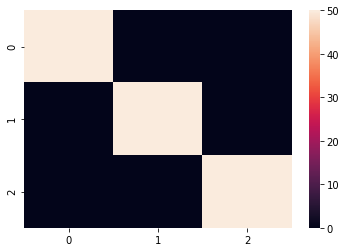

In [168]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap #<- seaborn is a plotting library, and "heatmap" is very useful for confusion matrices

confusion = confusion_matrix(y, y_predict)

heatmap(confusion)

The performance is perfect! We need to use a test/train split to avoid over-fitting:

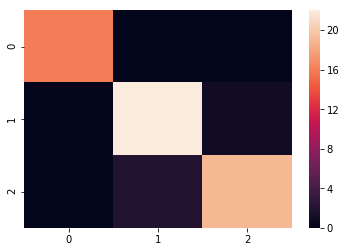

In [172]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

dtree.fit(X_train,y_train)
y_predict = dtree.predict(X_test)

confusion = confusion_matrix(y_test, y_predict)

heatmap(confusion)

We see that the performance is still relatively good, but classes 1 and 2 are often confused.

We can also use a visualization library to look at how the decision tree is working:

In [174]:
! pip install pydotplus

    100% |████████████████████████████████| 286kB 1.8MB/s ta 0:00:01
  Running setup.py bdist_wheel for pydotplus ... done
  Stored in directory: /Users/Lecturing/Library/Caches/pip/wheels/35/7b/ab/66fb7b2ac1f6df87475b09dc48e707b6e0de80a6d8444e3628
Successfully built pydotplus
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


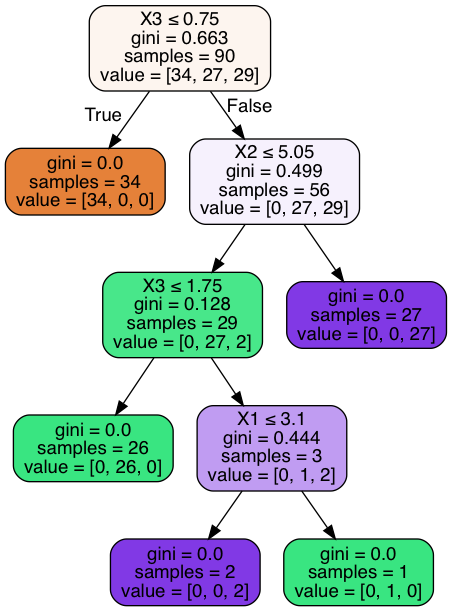

In [175]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

The criterion for each node is listed at the top of a block, the `value` category tells how many samples are sorted into each of the 3 categories, `samples` gives the total number of samples into a node, and the `gini` coefficient is a measure of class "impurity" related to how often a sample will be mis-categorized at a given node. 

Further analysis of decision trees is beyond the scope of this course, but they are very useful tools to know about.

## Classification conclusions

* There are two basic types of classification model: Generative and discriminative.
    - Discriminative models find a decision boundary based on differences between classes: P(y|X)
    - Generative models consider the properties of the distribution that underlies each class: P(X|y)

* When approaching a classification problem you should consider if it is **linearly separable**, **class imbalanced**, and **binary or multiclass**.

* It is important to consider the appropriate performance metrics for a classification problem. The **accuracy, precision, and recall** and the **ROC curve** are important measures for binary problems, and a **confusion matrix** is useful for multi-class problems.

* The "perceptron" or max cost model is the conceptual basis for logistic regression and support vector machines.
    - Logistic regression uses the "softmax" approximation to the max cost function
    - Support vector machines use the "margin" cost function, and apply a regularization term to maximize margins
    
* Kernel support vector machines are the classification equivalent of kernel ridge regression (both have  **$L_2$ regularized cost functions**)

* Linear discriminant analysis (LDA) assumes that all classes are normally distributed with equivalent covariance structures.
    - LDA is closely related to PCA
    - LDA is the supervised classification equivalent of partial least squares (PLS)
    
* Naive Bayes assumes independent multivariate Gaussian distributions for each class and derives probabilities based on Bayes' theorem.

* Decision trees use cutoffs on each feature to assign classes. They have the advantage of being easily interpretable, but are also prone to over-fitting.

## Further Reading

* [Machine Learning Refined - Chapter 4](http://docs.wixstatic.com/ugd/f09e45_6e2b4294ca2e46968c34071eed230d33.pdf)
* [Python Data Science Handbook chapter on support vector machines](https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html)
* Hastie Sec. 6.7, Ch. 12
* [Machine Learning Mastery: How to handle class imbalance](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)
* [Blog post on creating/visualizing decision trees](https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176)